In [4]:
import extendedcir
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
file_path = "data.xlsx"
ir_termS = pd.read_excel(file_path, sheet_name='interest_rate_term_structure')
cr_termS = pd.read_excel(file_path, sheet_name='credit_risk_term_structure')
ir_params = pd.read_excel(file_path, sheet_name='interest_rate_parameters')
cr_params = pd.read_excel(file_path, sheet_name='credit_risk_parameters')
ir_model = extendedcir.InterestRateCIRPP(ir_termS, ir_params['k'][0], ir_params['theta'][0], ir_params['sigma'][0], ir_params['x0'][0])
cr_model = extendedcir.CreditRiskCIRPP(ir_termS, cr_termS, cr_params['k'][0], cr_params['theta'][0], cr_params['sigma'][0], cr_params['x0'][0])
ssrd = extendedcir.SSRDSimulation(ir_model, cr_model, 0.8, 1000, 1/12, 5)

In [5]:
rt, ct, ft = ssrd.simulateMC()

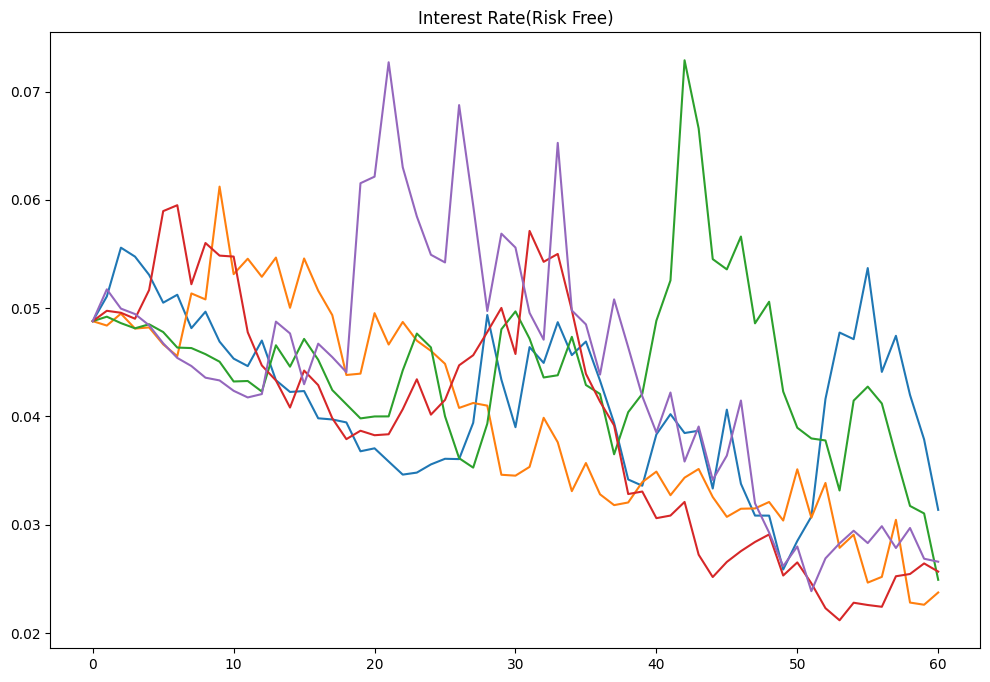

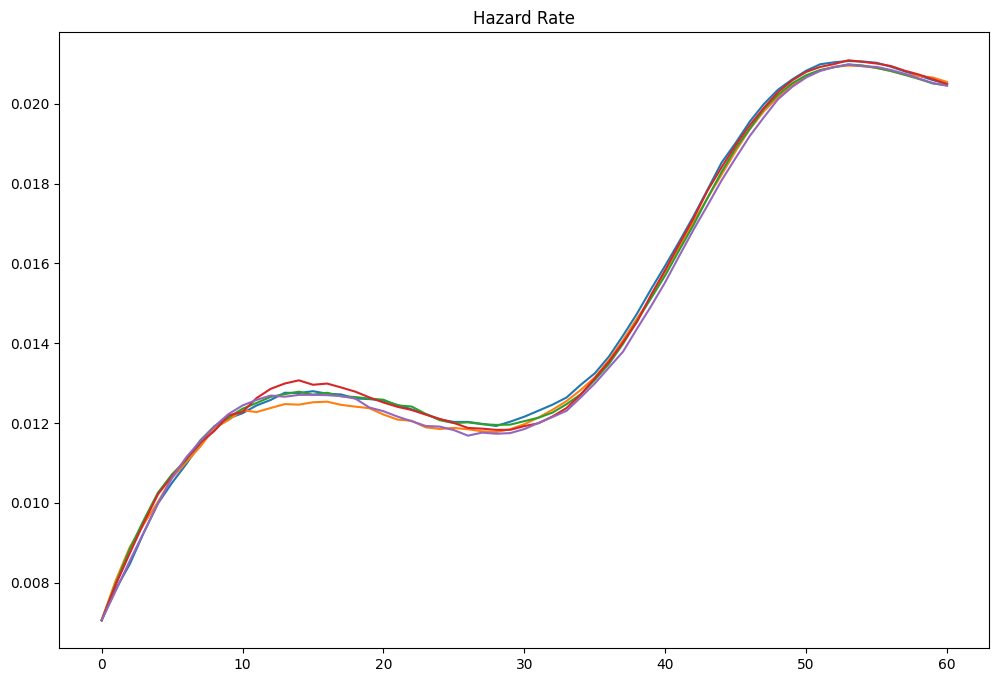

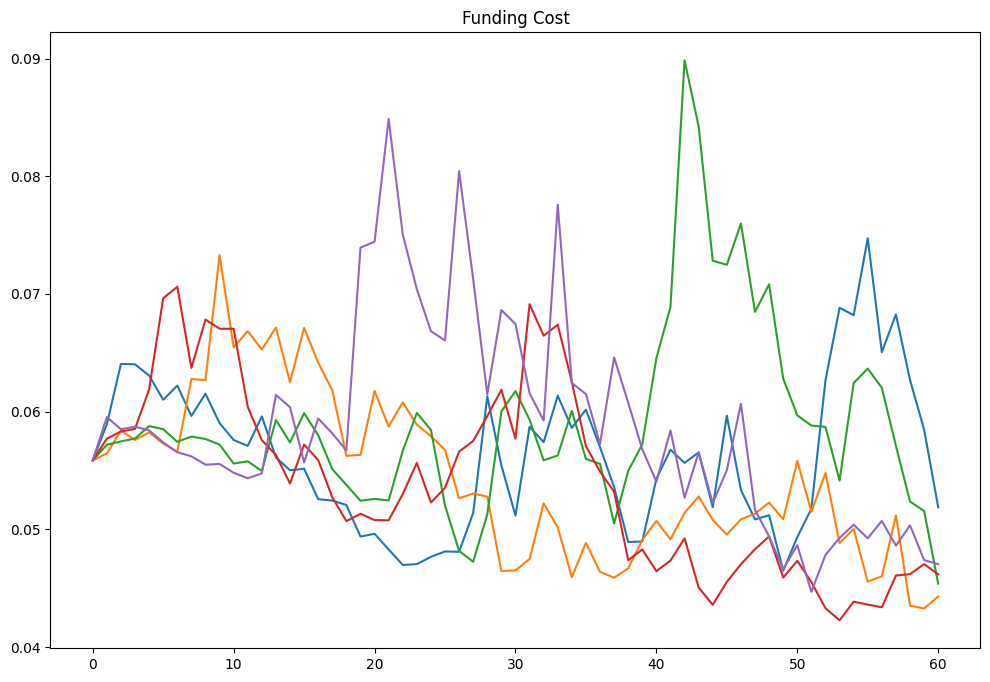

In [6]:
plt.figure(figsize=(12,8))
plt.plot(rt.T)
plt.title("Interest Rate(Risk Free)")
plt.figure(figsize=(12,8))
plt.plot(ct.T)
plt.title('Hazard Rate')
plt.figure(figsize=(12,8))
plt.plot(ft.T)
plt.title('Funding Cost');